<a href="https://colab.research.google.com/github/ahmdeltoky03/Image_Classification_using_cifar10/blob/main/Image_Classification_using_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The CIFAR-10 dataset is commonly used for image classification tasks. It contains 60,000 images split into 10 categories. The dataset is divided into 50,000 training images and 10,000 test images. For more details, you can visit the dataset page on Kaggle: [click here](https://www.kaggle.com/c/cifar-10/).

In [ ]:
# import needing libraries
import os
import shutil
import random

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
(train_images, train_labels) ,( test_images, test_labels) = datasets.cifar10.load_data()
np.savez('cifar10_dataset.npz',train_images=train_images, train_labels=train_labels, test_images=test_images, test_labels=test_labels)

In [ ]:
# Load dataset
train_images, train_labels, test_images, test_labels = np.load('cifar10_dataset.npz').values()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Split the data into training and validation sets
num_train = len(train_images)
num_train_split = int(num_train * 0.85)

train_images, val_images = train_images[:num_train_split], train_images[num_train_split:]
train_labels, val_labels = train_labels[:num_train_split], train_labels[num_train_split:]


# # Save the images into folders for train and validation sets
# def save_images_to_folder(images, labels, folder_prefix):
#     for i in range(len(images)):
#         label = labels[i][0]
#         folder_name = class_names[label]

#         if not os.path.exists(f"{folder_prefix}_images/{folder_name}"):
#             os.makedirs(f"{folder_prefix}_images/{folder_name}")

#         img = images[i]
#         plt.imsave(f"{folder_prefix}_images/{folder_name}/image_{i}.png", img)

# # Save training images
# save_images_to_folder(train_images, train_labels, "train")

# # Save validation images
# save_images_to_folder(val_images, val_labels, "val")

# # Save test images
# for i in range(len(test_images)):
#     label = test_labels[i][0]
#     folder_name = class_names[label]

#     if not os.path.exists(f"test_images/{folder_name}"):
#         os.makedirs(f"test_images/{folder_name}")

#     img = test_images[i]
#     plt.imsave(f"test_images/{folder_name}/image_{i}.png", img)


In [ ]:
print("Length of Train Images : ", len(train_images))
print("Length of Train Labels : ", len(train_labels))
print("Length of Validation Images : ", len(val_images))
print("Length of Validation Labels : ", len(val_labels))
print("Length of Test Images : ", len(test_images))
print("Length of Test Labels : ", len(test_labels))

Length of Train Images :  42500
Length of Train Labels :  42500
Length of Validation Images :  7500
Length of Validation Labels :  7500
Length of Test Images :  10000
Length of Test Labels :  10000


## Display Some Samples

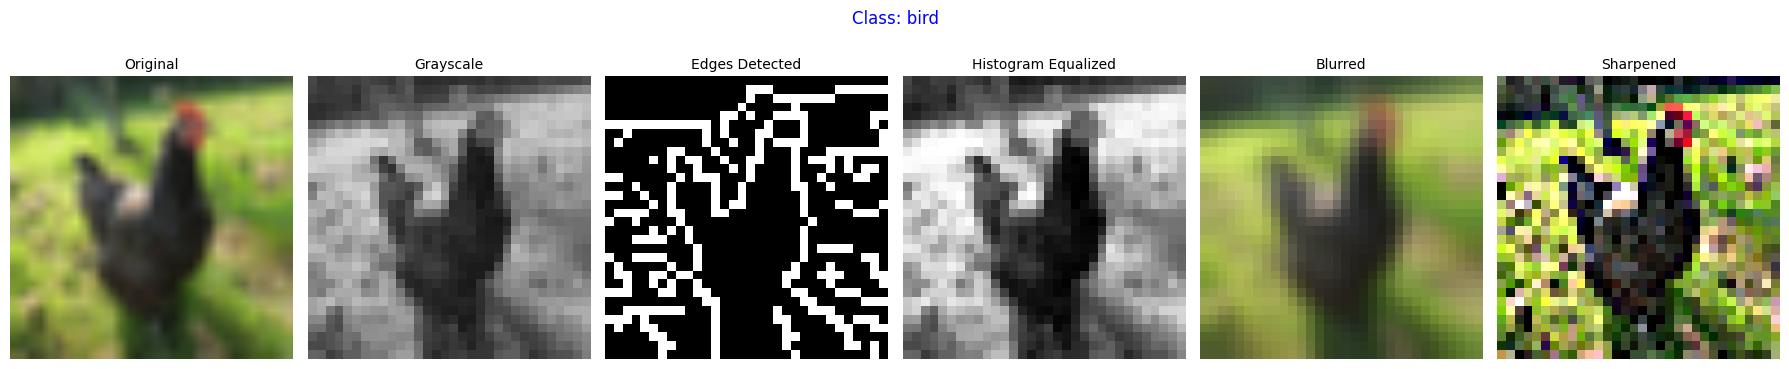

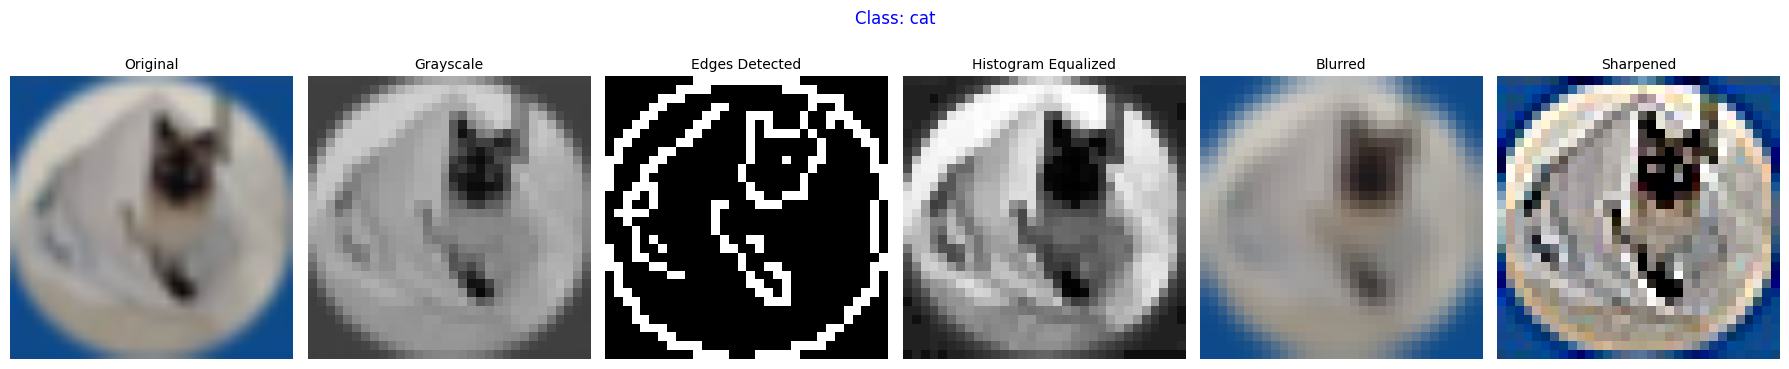

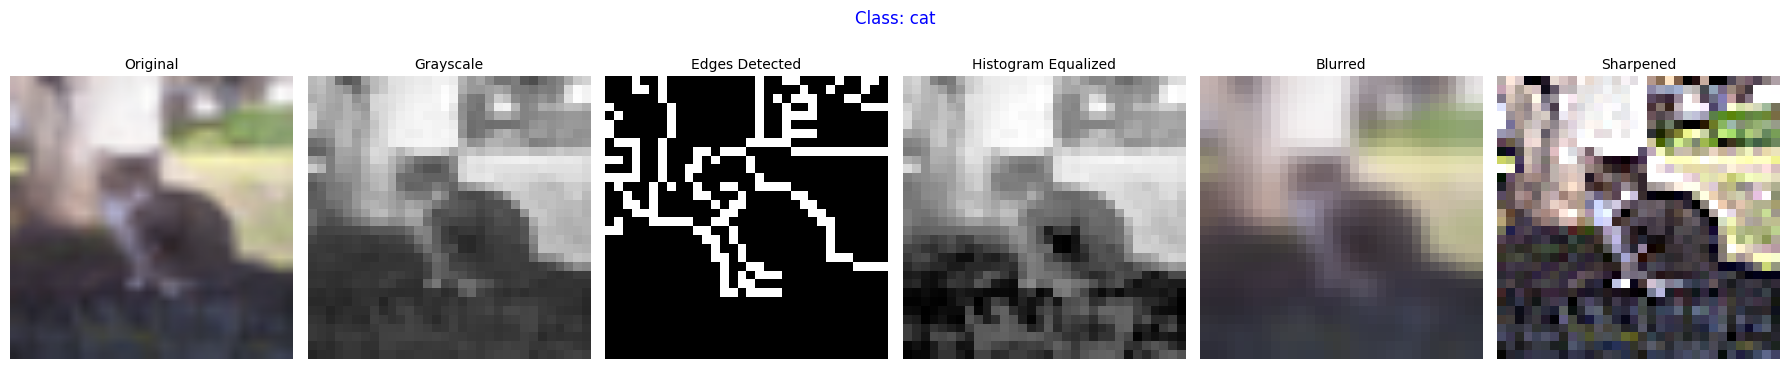

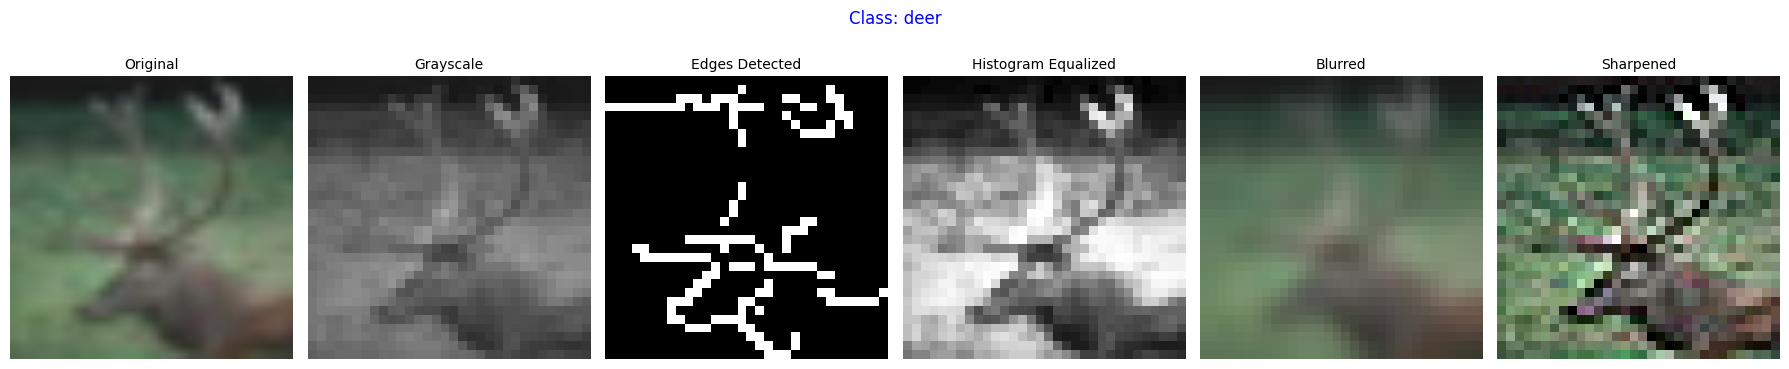

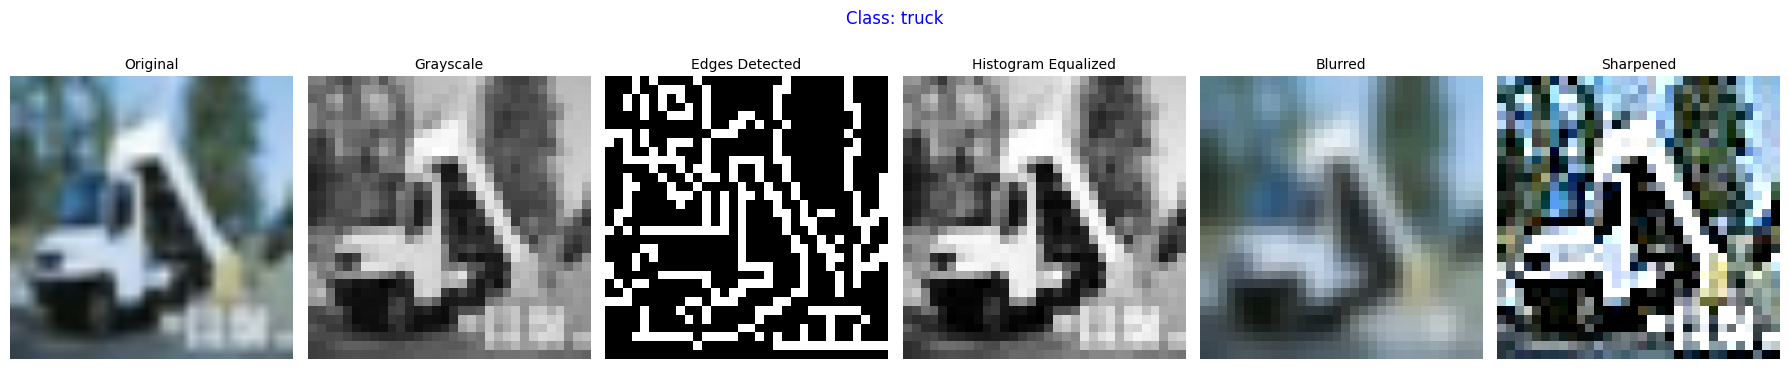

In [ ]:
import cv2
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def display_image_transformations(images, labels, class_names, n_samples=5):
    """
    Displays images with different transformations:
    - Original
    - Grayscale
    - Edge Detection
    - Histogram Equalization
    - Gaussian Blurring
    - Sharpened

    Parameters:
    - images.
    - labels.
    - class_names.
    - n_samples: Number of images to display.

    Output:
    - Displays n_samples images, each processed in 6 different transformations.
    - 1 -- 6
    - n_samples -- 6 * n_samples
    """

    # Select random indices
    sample_indices = np.random.choice(len(images), n_samples, replace=False)

    for idx in sample_indices:
        img = images[idx]
        label = class_names[labels[idx][0]]

        img_resized = cv2.resize(img, (224, 224))

        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        edges_detected_image = cv2.Canny(gray_image, 100, 200)
        equalized_image = cv2.equalizeHist(gray_image)
        blurred_image = cv2.GaussianBlur(img, (5, 5), 0)

        # Sharpening filter
        sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        sharpened_image = cv2.filter2D(img, -1, sharpening_kernel)

        gray_image_rgb = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
        edges_detected_rgb = cv2.cvtColor(edges_detected_image, cv2.COLOR_GRAY2RGB)
        equalized_rgb = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2RGB)

        # Store processed images
        processed_images = [
            ("Original", img_resized),
            ("Grayscale", gray_image_rgb),
            ("Edges Detected", edges_detected_rgb),
            ("Histogram Equalized", equalized_rgb),
            ("Blurred", blurred_image),
            ("Sharpened", sharpened_image)
        ]

        # Plot results
        fig, axes = plt.subplots(1, len(processed_images), figsize=(18, 4))
        for i, (title, processed_img) in enumerate(processed_images):
            axes[i].imshow(processed_img)
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')

        plt.suptitle(f"Class: {label}", fontsize=12, color="blue")
        plt.tight_layout()
        plt.show()

# test
display_image_transformations(train_images, train_labels, class_names, n_samples=5)


In [ ]:
# # prepare image for train, validation and test
# def prepare_image_data (image_dir):
#     image_data = []
#     labels = []
#     class_names = os.listdir(image_dir)

#     for class_index, class_name in enumerate(class_names):
#         class_folder = os.path.join(image_dir, class_name)

#         # Check if it's a directory (to ensure no non-image files are in the list)
#         if os.path.isdir(class_folder):
#             for img_file in os.listdir(class_folder):
#                 img_path = os.path.join(class_folder, img_file)

#                 if img_path.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
#                     img = image.load_img(img_path, target_size=(32, 32))  # Resize to 32x32
#                     img_array = image.img_to_array(img)

#                     # Normalize the image to range [0, 1]
#                     img_array = img_array / 255.0

#                     image_data.append(img_array)
#                     labels.append(class_index)

#     # Convert to numpy arrays
#     image_data = np.array(image_data)
#     labels = np.array(labels)

#     return image_data, labels

# train_images_normalized, train_labels = prepare_image_data (train_images_dir)
# val_images_normalized, val_labels = prepare_image_data (val_images_dir)
# test_images_normalized, test_labels = prepare_image_data (test_images_dir)

# print("Length of Train Images : ", len(train_images_normalized))
# print("Length of Train Labels : ", len(train_labels))
# print("Length of Validation Images : ", len(val_images_normalized))
# print("Length of Validation Labels : ", len(val_labels))
# print("Length of Test Images : ", len(test_images_normalized))
# print("Length of Test Labels : ", len(test_labels))


# Journay To Increase Model Performance From **Classical ML** To **Pretrained Model**

### Classical ML

###### prepare images for classical machine learning


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Flatten images
# 32*32*3 = 3072
train_images_ml = train_images.reshape(len(train_images), -1)
val_images_ml = val_images.reshape(len(val_images), -1)
test_images_ml = test_images.reshape(len(test_images), -1)

# Normalized step
scaler = StandardScaler()
train_images_ml = scaler.fit_transform(train_images_ml)
val_images_ml = scaler.transform(val_images_ml)
test_images_ml = scaler.transform(test_images_ml)

In [ ]:
# model
knn = KNeighborsClassifier()
knn.fit(train_images_ml, train_labels.flatten())

# prediction
val_predictions = knn.predict(val_images_ml)

print("Accuracy Score : ", accuracy_score(val_labels.flatten(), val_predictions))
print(classification_report(val_labels.flatten(), val_predictions))

Accuracy Score :  0.3333333333333333
              precision    recall  f1-score   support

           0       0.38      0.52      0.44       761
           1       0.67      0.20      0.31       749
           2       0.22      0.44      0.29       715
           3       0.32      0.23      0.27       772
           4       0.21      0.47      0.29       729
           5       0.42      0.22      0.29       799
           6       0.34      0.27      0.30       738
           7       0.71      0.21      0.32       731
           8       0.40      0.67      0.50       750
           9       0.69      0.11      0.20       756

    accuracy                           0.33      7500
   macro avg       0.44      0.33      0.32      7500
weighted avg       0.44      0.33      0.32      7500



In [ ]:
  cm = confusion_matrix(val_labels.flatten(), val_predictions)
  fig = ff.create_annotated_heatmap(cm, x=class_names , y=class_names, colorscale='Blues')
  fig.show()

In [ ]:
# model
rf = RandomForestClassifier()
rf.fit(train_images_ml, train_labels.flatten())

# prediction
val_predictions = rf.predict(val_images_ml)

print("Accuracy Score : ", accuracy_score(val_labels.flatten(), val_predictions))
print(classification_report(val_labels.flatten(), val_predictions))

Accuracy Score :  0.4550666666666667
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       761
           1       0.48      0.53      0.50       749
           2       0.35      0.33      0.34       715
           3       0.36      0.28      0.31       772
           4       0.39      0.40      0.40       729
           5       0.38      0.33      0.36       799
           6       0.45      0.54      0.49       738
           7       0.52      0.45      0.48       731
           8       0.58      0.63      0.60       750
           9       0.46      0.55      0.50       756

    accuracy                           0.46      7500
   macro avg       0.45      0.46      0.45      7500
weighted avg       0.45      0.46      0.45      7500



In [ ]:
  cm = confusion_matrix(val_labels.flatten(), val_predictions)
  fig = ff.create_annotated_heatmap(cm, x=class_names , y=class_names, colorscale='Blues')
  fig.show()

### Convolutional Neural Network (CNN)

##### Normalize Images And Convert Labels to One-Hot Encoding


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# scaled images between 0 -- 1
train_images_cnn = train_images / 255.0
val_images_cnn = val_images / 255.0
test_images_cnn = test_images / 255.0

# Convert labels to one-hot encoding
train_labels_cnn = to_categorical(train_labels, 10)
val_labels_cnn = to_categorical(val_labels, 10)
test_labels_cnn = to_categorical(test_labels, 10)

print(f"Train Images Shape using CNN: {train_images_cnn.shape}")
print(f"Validation Images Shape using CNN: {val_images_cnn.shape}")
print(f"Test Images Shape using CNN: {test_images_cnn.shape}")


Train Images Shape using CNN: (42500, 32, 32, 3)
Validation Images Shape using CNN: (7500, 32, 32, 3)
Test Images Shape using CNN: (10000, 32, 32, 3)


array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
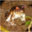

In [ ]:
train_images[0]

In [ ]:
train_images_cnn[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [ ]:
train_images_cnn[0].shape

(32, 32, 3)

##### Build Deep Learning Model

In [ ]:
def build_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = train_images_cnn[0].shape))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'softmax'))
  return model

model = build_model()

# Callbacks
filepath = "best_model.keras"
early_stopping = EarlyStopping(monitor='val_loss',
                               verbose=1,
                               mode='min',
                               patience=4)
model_check_point = ModelCheckpoint(filepath,monitor='val_loss',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto',
                                    save_freq='epoch')
reduce_on_plateau = ReduceLROnPlateau(monitor='val_accuracy',
                                      patience=3,
                                      min_lr= 1e-6,
                                      verbose=1,
                                      factor=.5)

# Compile the model
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = model.fit(train_images_cnn, train_labels_cnn, epochs=50, batch_size=64,
                        validation_data=(val_images_cnn, val_labels_cnn))

Epoch 1/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2239 - loss: 2.0567 - val_accuracy: 0.4428 - val_loss: 1.5165
Epoch 2/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4432 - loss: 1.5254 - val_accuracy: 0.5019 - val_loss: 1.4241
Epoch 3/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5113 - loss: 1.3701 - val_accuracy: 0.5743 - val_loss: 1.2124
Epoch 4/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5534 - loss: 1.2697 - val_accuracy: 0.6023 - val_loss: 1.1282
Epoch 5/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5813 - loss: 1.1910 - val_accuracy: 0.6165 - val_loss: 1.1075
Epoch 6/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6059 - loss: 1.1258 - val_accuracy: 0.6389 - val_loss: 1.0389
Epoch 7/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6218 - loss: 1.0873 - val_accuracy: 0.6429 - val_loss: 1.0246
Epoch 8/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6365 - loss: 1.0422 - val_accuracy: 0.

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,256 (860.38 KB)

 Trainable params: 73,418 (286.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,838 (573.59 KB)

##### I notice If I add more epochs model accuracy will be increased.

In [ ]:
# test model
test_loss , test_accuracy = model.evaluate(test_images_cnn, test_labels_cnn)
print("Test Accuracy : ", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7050 - loss: 1.1243
Test Accuracy :  0.7024000287055969


In [ ]:
# print(history.history.keys())

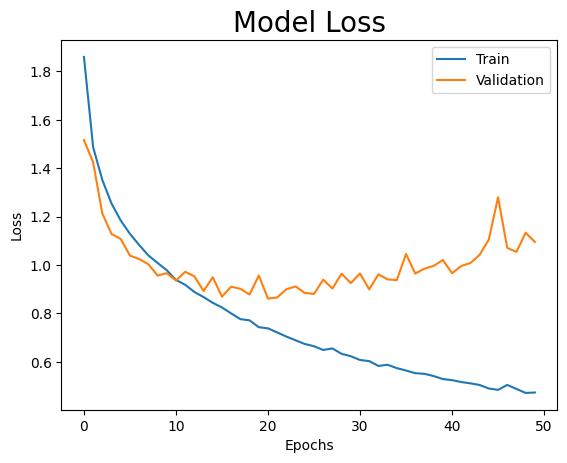

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

##### Prefer 20 Epochs

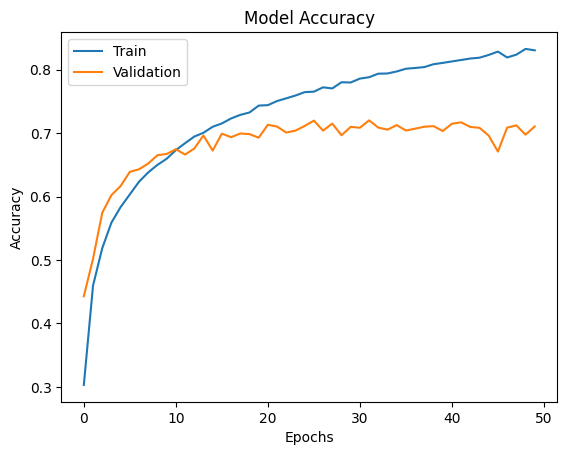

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


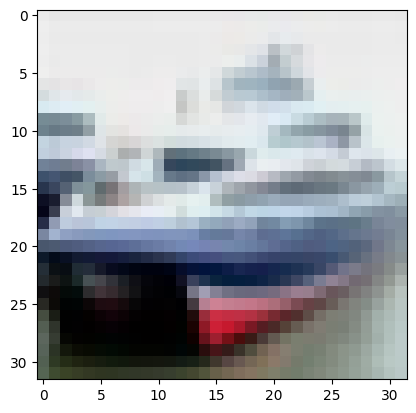

Predicted Class: ship


In [ ]:
## test model
image = np.expand_dims(test_images_cnn[1], axis=0)
predictions = model.predict(image)

plt.imshow(test_images[1])
plt.show()

# Get the class with the highest probability
predicted_class = np.argmax(predictions)
print(f"Predicted Class: {class_names[predicted_class]}")


### Use Pretrained Model (VGG19)

In [ ]:
from tensorflow.keras.applications import VGG19


base_model = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(32, 32, 3))

# to avoid weight updates
for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

vgg_19_model = Model(inputs=base_model.input, outputs=output)

# Callbacks
filepath = "vgg19_best_model.keras"
early_stopping = EarlyStopping(monitor='val_loss',
                               verbose=1,
                               mode='min',
                               patience=4)
model_check_point = ModelCheckpoint(filepath,monitor='val_loss',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto',
                                    save_freq='epoch')
reduce_on_plateau = ReduceLROnPlateau(monitor='val_accuracy',
                                      patience=3,
                                      min_lr= 1e-6,
                                      verbose=1,
                                      factor=.5)

vgg_19_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


history = vgg_19_model.fit(train_images_cnn, train_labels_cnn,
                                      epochs=35, batch_size=64,
                                      callbacks=[early_stopping,model_check_point,reduce_on_plateau],
                                      validation_data=(val_images_cnn, val_labels_cnn))

Epoch 1/35
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3284 - loss: 1.8660
Epoch 1: val_loss improved from inf to 1.38514, saving model to best_model.keras
665/665 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.3285 - loss: 1.8657 - val_accuracy: 0.5037 - val_loss: 1.3851 - learning_rate: 0.0010
Epoch 2/35
664/665 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4824 - loss: 1.4700
Epoch 2: val_loss improved from 1.38514 to 1.31005, saving model to best_model.keras
665/665 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.4824 - loss: 1.4700 - val_accuracy: 0.5355 - val_loss: 1.3100 - learning_rate: 0.0010
Epoch 3/35
664/665 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5107 - loss: 1.4002
Epoch 3: val_loss improved from 1.31005 to 1.25507, saving model to best_model.keras
665/665 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.5107 - loss: 1.4002 - val_accuracy: 0.5576 - val_loss: 1.2551 - learning_rate: 0.0010
Epoch 4/35
663/665 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accu

In [ ]:
vgg_19_model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,248,096 (77.24 MB)

 Trainable params: 74,570 (291.29 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 149,142 (582.59 KB)

In [ ]:
# model accuracy
test_loss, test_accuracy = vgg_19_model.evaluate(test_images_cnn, test_labels_cnn)
print("Test Accuracy : ", test_accuracy)
# print("Test Loss : ", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5983 - loss: 1.1403
Test Accuracy :  0.597100019454956


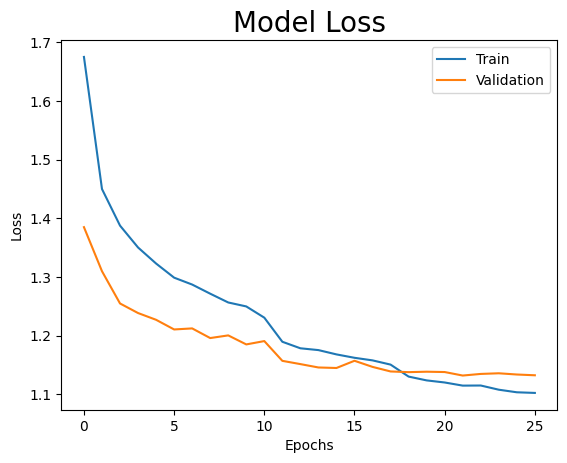

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

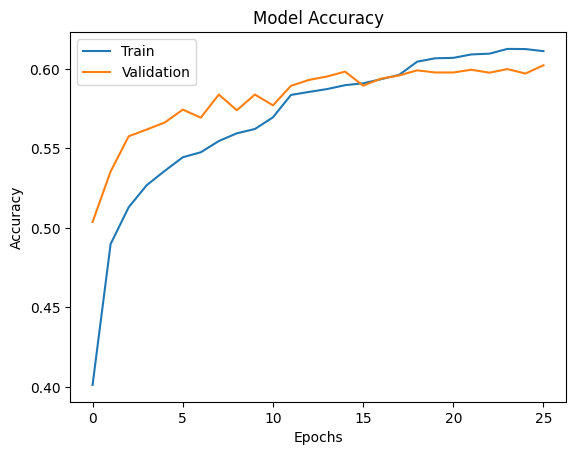

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Use Another Pretrained Model (MobileNetV2)

In [ ]:
from tensorflow.keras.applications import MobileNetV2


base_model = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(32, 32, 3))

# to avoid weight updates
for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

MobileNetV2_model = Model(inputs=base_model.input, outputs=output)

# Callbacks
filepath = "MobileNetV2_best_model.keras"
early_stopping = EarlyStopping(monitor='val_loss',
                               verbose=1,
                               mode='min',
                               patience=4)
model_check_point = ModelCheckpoint(filepath,monitor='val_loss',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto',
                                    save_freq='epoch')
reduce_on_plateau = ReduceLROnPlateau(monitor='val_accuracy',
                                      patience=3,
                                      min_lr= 1e-6,
                                      verbose=1,
                                      factor=.5)

MobileNetV2_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# history = vgg_19_model.fit(train_images_cnn, train_labels_cnn,
#                                       epochs=5, batch_size=128,
#                                       validation_data=(val_images_cnn, val_labels_cnn))

history = MobileNetV2_model.fit(train_images_cnn, train_labels_cnn,
                                      epochs=25, batch_size=64,
                                      callbacks=[early_stopping,model_check_point,reduce_on_plateau],
                                      validation_data=(val_images_cnn, val_labels_cnn))

Epoch 1/25
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3220 - loss: 1.8753
Epoch 1: val_loss improved from inf to 1.37391, saving model to best_model.keras
665/665 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.3221 - loss: 1.8750 - val_accuracy: 0.5052 - val_loss: 1.3739 - learning_rate: 0.0010
Epoch 2/25
662/665 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4857 - loss: 1.4569
Epoch 2: val_loss improved from 1.37391 to 1.30695, saving model to best_model.keras
665/665 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.4857 - loss: 1.4568 - val_accuracy: 0.5385 - val_loss: 1.3070 - learning_rate: 0.0010
Epoch 3/25
662/665 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5129 - loss: 1.3890
Epoch 3: val_loss improved from 1.30695 to 1.27548, saving model to best_model.keras
665/665 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.5129 - loss: 1.3890 - val_accuracy: 0.5527 - val_loss: 1.2755 - learning_rate: 0.0010
Epoch 4/25
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accu

In [ ]:
# model accuracy
test_loss, test_accuracy = MobileNetV2_model.evaluate(test_images_cnn, test_labels_cnn)
print("Test Accuracy : ", test_accuracy)
# print("Test Loss : ", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6038 - loss: 1.1397
Test Accuracy :  0.5996999740600586


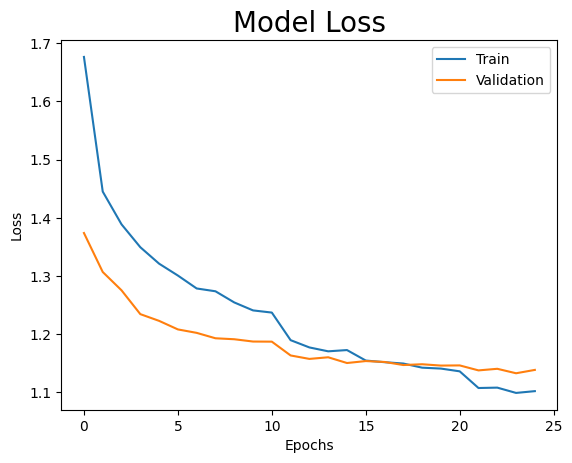

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

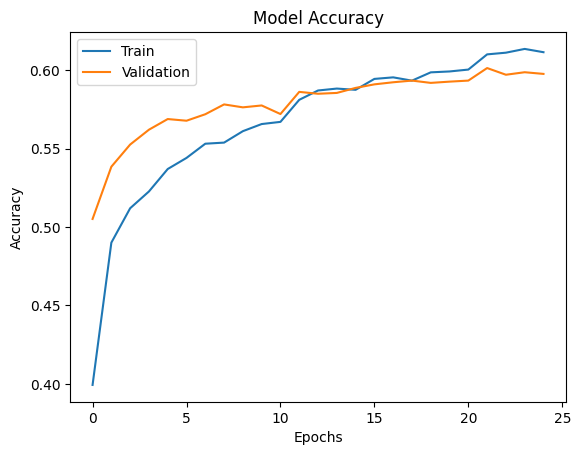

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Use Another Pretrained Model (ResNet50)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',verbose=1,mode='min',patience=4)

filepath = "ResNet50_best_model.keras"

model_checkpoint = ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=True,
                                  save_weights_only=False,mode='auto',save_freq='epoch')

# Train the model with early stopping and model checkpointing
history = model.fit(train_images_cnn,train_labels_cnn,
                    validation_data=(val_images_cnn, val_labels_cnn),
                    epochs=5, callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1972 - loss: 2.1975
Epoch 1: val_loss improved from inf to 1.94563, saving model to best_model.keras
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.1972 - loss: 2.1974 - val_accuracy: 0.2964 - val_loss: 1.9456
Epoch 2/5
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2983 - loss: 1.9170
Epoch 2: val_loss improved from 1.94563 to 1.83636, saving model to best_model.keras
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.2983 - loss: 1.9169 - val_accuracy: 0.3383 - val_loss: 1.8364
Epoch 3/5
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3318 - loss: 1.8434
Epoch 3: val_loss did not improve from 1.83636
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.3318 - loss: 1.8434 - val_accuracy: 0.3063 - val_loss: 1.8814
Epoch 4/5
1326/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3454 - loss: 1.8061
Epoch 4: val_loss did not improve from 1.83636
1329/1329 ━━━━━━━━━━━━━━━━━━

### Hyperparameter Tuning Step

In [ ]:
# Install Keras Tuner
!pip install -qU keras-tuner

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch


def build_model(hp):

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())

    model.add(Dense(units=hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(10, activation='softmax'))


    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.0001])),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='simple_tuning',
    project_name='cifar10'
)

tuner.search(train_images_cnn, train_labels_cnn,
             epochs=25, validation_data=(val_images_cnn, val_labels_cnn),
             shuffle=True, batch_size=128)


# best model during the tuning
best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()


Trial 3 Complete [00h 03m 54s]
val_accuracy: 0.6294666528701782

Best val_accuracy So Far: 0.6294666528701782
Total elapsed time: 00h 12m 03s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 192)                 │          98,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,815,114 (56.52 MB)

 Trainable params: 100,426 (392.29 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# test model
test_loss , test_accuracy = model.evaluate(test_images_cnn, test_labels_cnn)
print("Test Accuracy : ", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3804 - loss: 1.7458
Test Accuracy :  0.37470000982284546


### Build Complex Model Using CNN

In [ ]:
train_images_cnn[0].shape

(32, 32, 3)

In [ ]:
def build_model():

    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=train_images_cnn[0].shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

model = build_model()

# Callbacks
filepath = "best_model.keras"
early_stopping = EarlyStopping(monitor='val_loss',
                               verbose=1,
                               mode='min',
                               patience=4)
model_check_point = ModelCheckpoint(filepath,monitor='val_loss',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto',
                                    save_freq='epoch')
reduce_on_plateau = ReduceLROnPlateau(monitor='val_accuracy',
                                      patience=3,
                                      min_lr= 1e-6,
                                      verbose=1,
                                      factor=.5)

# Compile the model
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = model.fit(train_images_cnn, train_labels_cnn, epochs=50, batch_size=64,
                        validation_data=(val_images_cnn, val_labels_cnn))

model.save('cnn_model.keras')

Epoch 1/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.3194 - loss: 2.0333 - val_accuracy: 0.5309 - val_loss: 1.3203
Epoch 2/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5569 - loss: 1.2464 - val_accuracy: 0.4713 - val_loss: 1.6193
Epoch 3/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6582 - loss: 0.9943 - val_accuracy: 0.6384 - val_loss: 1.0183
Epoch 4/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7203 - loss: 0.8368 - val_accuracy: 0.7135 - val_loss: 0.8349
Epoch 5/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7721 - loss: 0.6908 - val_accuracy: 0.6029 - val_loss: 1.1507
Epoch 6/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8100 - loss: 0.5729 - val_accuracy: 0.7352 - val_loss: 0.7916
Epoch 7/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8290 - loss: 0.5167 - val_accuracy: 0.7675 - val_loss: 0.7120
Epoch 8/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8629 - loss: 0.4181 - val_

In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 4, 4, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,864,416 (18.56 MB)

 Trainable params: 1,621,002 (6.18 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 3,242,006 (12.37 MB)

In [ ]:
# save model
model.save('cnn_model.keras')

In [ ]:
# model accuracy
test_loss, test_accuracy = model.evaluate(test_images_cnn, test_labels_cnn)
print("Test Accuracy : ", test_accuracy)
# print("Test Loss : ", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7948 - loss: 1.4469
Test Accuracy :  0.7882999777793884


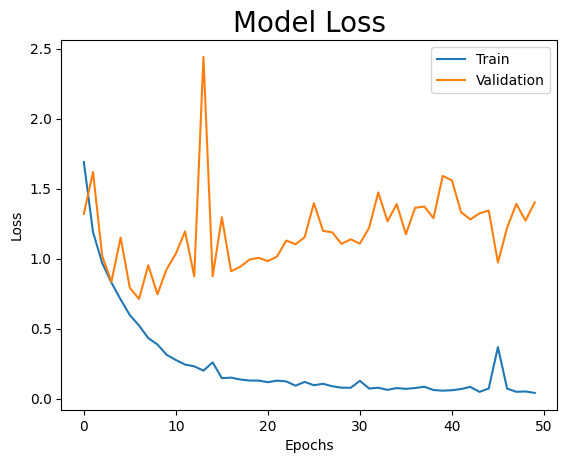

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

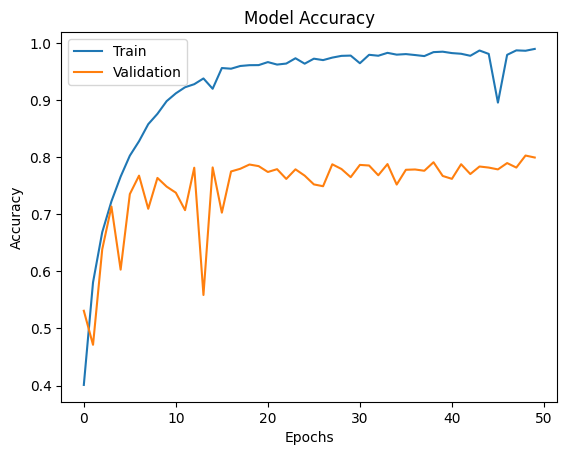

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### prefer using only 20 epochs to train model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


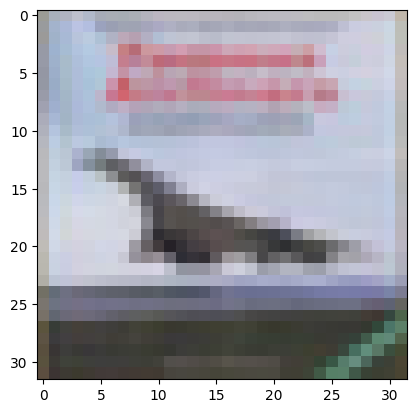

Predicted Class: airplane


In [ ]:
## test model
image = np.expand_dims(test_images_cnn[3], axis=0)
predictions = model.predict(image)

plt.imshow(test_images[3])
plt.show()

# Get the class with the highest probability
predicted_class = np.argmax(predictions)
print(f"Predicted Class: {class_names[predicted_class]}")

### **Model Architecture**

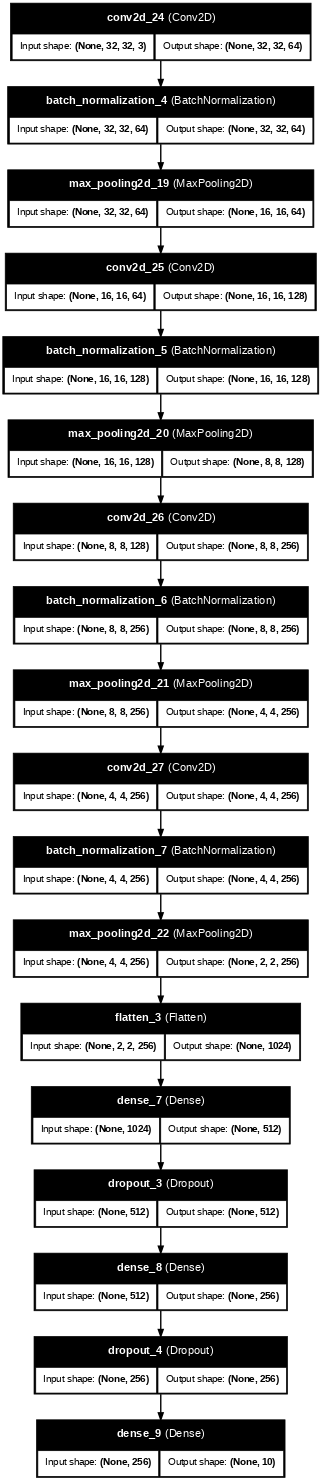

In [ ]:
tf.keras.utils.plot_model(model,
                          to_file='model_small.png',
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=50)

### Test The Final Model

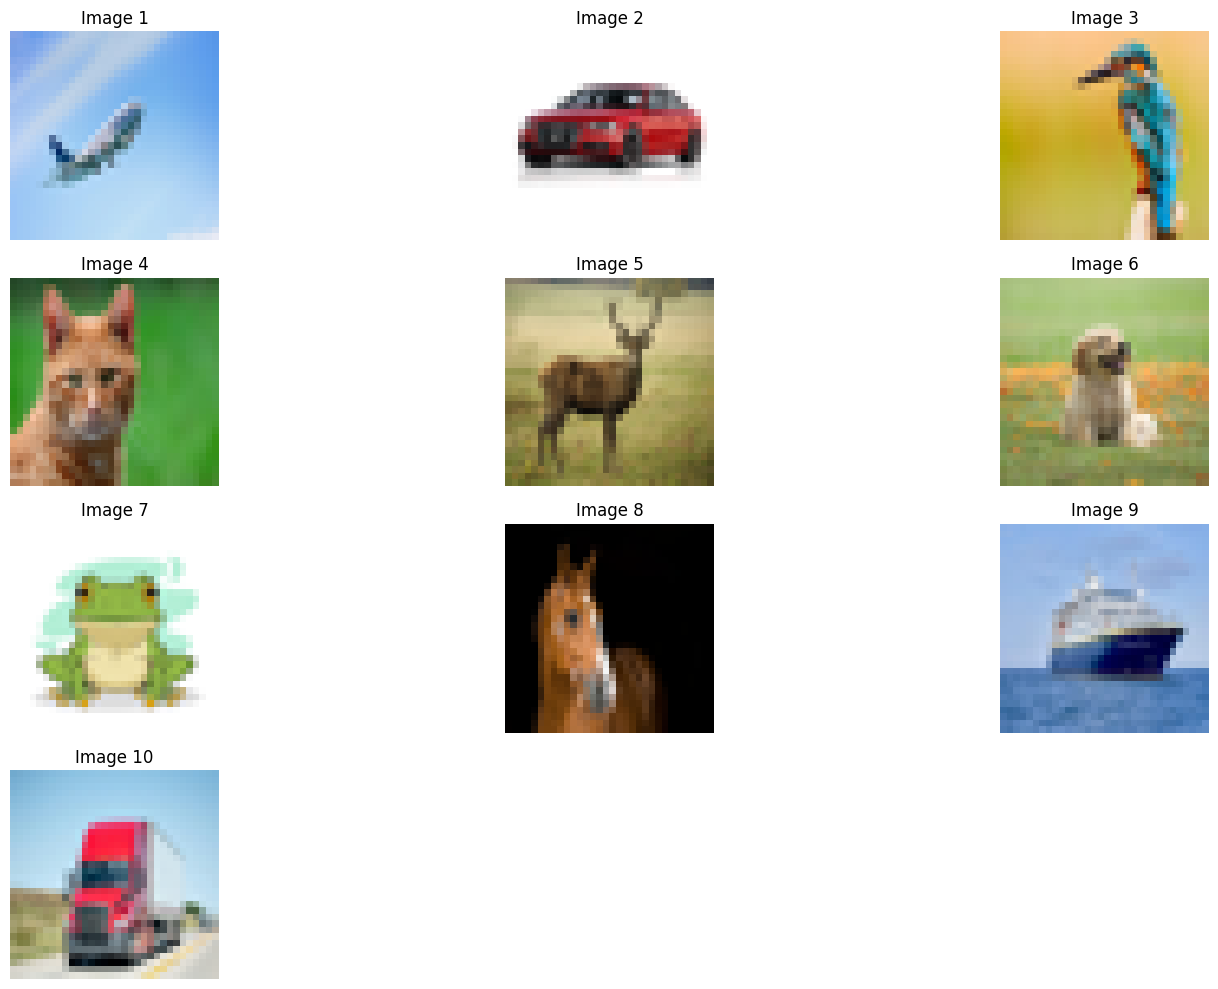

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# some samples
image_urls = [
    'https://bsmedia.business-standard.com/_media/bs/img/article/2024-08/07/full/1722995892-9811.jpg?im=FeatureCrop,size=(826,465)',  # Airplane
    'https://freepngimg.com/thumb/car/31608-7-car-photos-thumb.png',  # Automobile
    'https://cdn.pixabay.com/photo/2017/02/07/16/47/kingfisher-2046453_640.jpg',  # Bird
    'https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg',  # Cat
    'https://plus.unsplash.com/premium_photo-1661819541230-034d07819c9b?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MXx8ZGVlcnxlbnwwfHwwfHx8MA%3D%3D',  # Deer
    'https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=0.752xw:1.00xh;0.175xw,0&resize=1200:*',  # Dog
    'https://img.freepik.com/free-vector/hand-drawn-frog-cartoon-illustration_52683-161690.jpg',  # Frog
    'https://cdn.pixabay.com/photo/2018/05/11/11/11/horse-3390256_1280.jpg',  # Horse
    'https://www.nationalgeographic.com/content/dam/expeditions/transports/islander-ii/new-day-2-islander-ii-jan23-1000x666.jpg.adapt.six-sixty-seven.jpg',  # Ship
    'https://plus.unsplash.com/premium_photo-1664695368767-c42483a0bda1?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NXx8dHJ1Y2t8ZW58MHx8MHx8fDA%3D',  # Truck
]

plt.figure(figsize=(15, 10))

for i, url in enumerate(image_urls):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img = img.resize((32, 32))

        plt.subplot(4, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i+1}")

    except Exception as e:
        continue
plt.tight_layout()
plt.show()

### Model Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


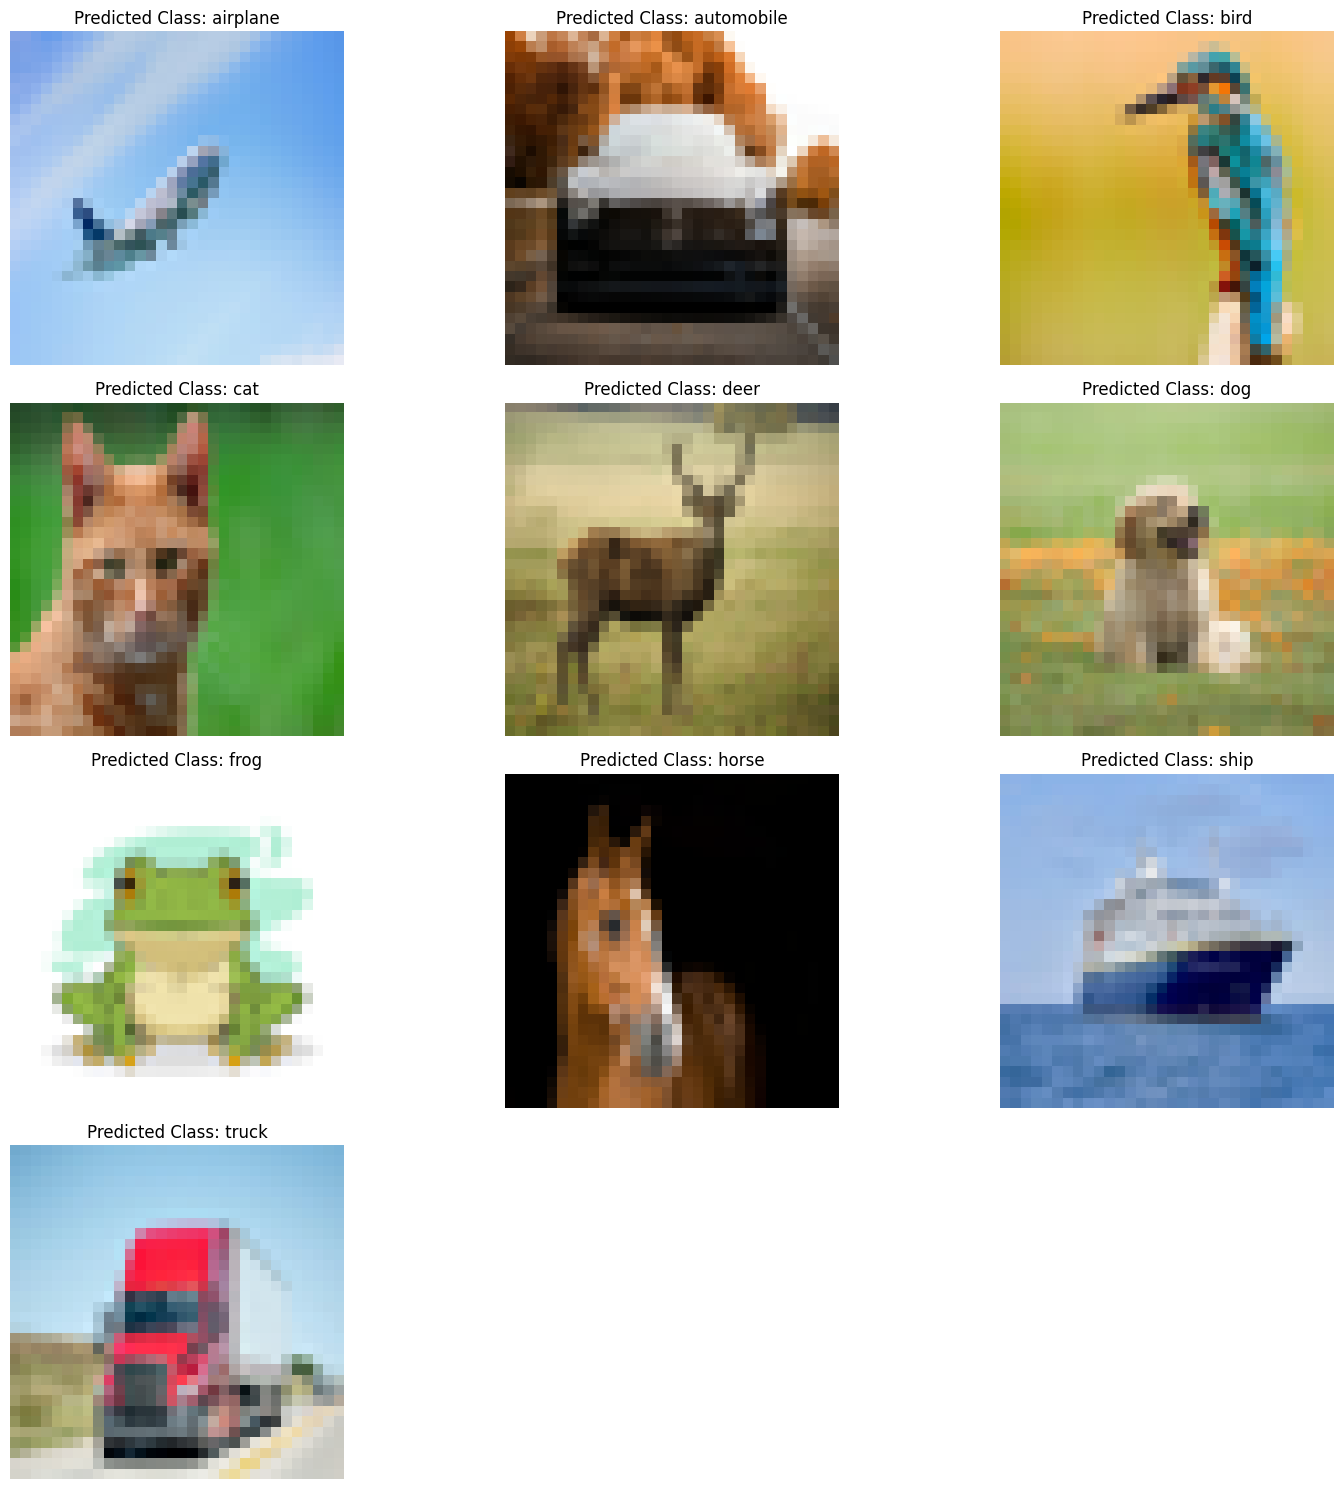

In [ ]:
image_urls = [
    'https://bsmedia.business-standard.com/_media/bs/img/article/2024-08/07/full/1722995892-9811.jpg?im=FeatureCrop,size=(826,465)',  # Airplane
    'https://images.unsplash.com/photo-1583267746897-2cf415887172?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8YXV0b21vYmlsZXxlbnwwfHwwfHx8MA%3D%3D',  # Automobile
    'https://cdn.pixabay.com/photo/2017/02/07/16/47/kingfisher-2046453_640.jpg',  # Bird
    'https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg',  # Cat
    'https://plus.unsplash.com/premium_photo-1661819541230-034d07819c9b?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MXx8ZGVlcnxlbnwwfHwwfHx8MA%3D%3D',  # Deer
    'https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=0.752xw:1.00xh;0.175xw,0&resize=1200:*',  # Dog
    'https://img.freepik.com/free-vector/hand-drawn-frog-cartoon-illustration_52683-161690.jpg',  # Frog
    'https://cdn.pixabay.com/photo/2018/05/11/11/11/horse-3390256_1280.jpg',  # Horse
    'https://www.nationalgeographic.com/content/dam/expeditions/transports/islander-ii/new-day-2-islander-ii-jan23-1000x666.jpg.adapt.six-sixty-seven.jpg',  # Ship
    'https://plus.unsplash.com/premium_photo-1664695368767-c42483a0bda1?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NXx8dHJ1Y2t8ZW58MHx8MHx8fDA%3D',  # Truck
]

plt.figure(figsize=(15, 15))
for i,img in enumerate(image_urls):
    try:
      response = requests.get(img)
      img = Image.open(BytesIO(response.content))
      img = img.resize((32, 32)) # resized image_size
      img = np.array(img) / 255.0 # normalized image_pixel
      img = np.expand_dims(img, axis=0)

      # model's predictions
      predictions = model.predict(img)
      predicted_class = np.argmax(predictions)

      # plot image
      plt.subplot(4, 3, i+1)
      plt.imshow(img[0])
      plt.title(f"Predicted Class: {class_names[predicted_class]}")
      plt.axis('off')
    except Exception as e:
      continue
plt.tight_layout()
plt.show()

## Thank You